# Decision Tree with Cross-Validation and Post-Pruning

This notebook demonstrates the process of training a Decision Tree classifier for image classification using the **CoronaHack Chest X-Ray Dataset**. The key steps include:

- Data loading and preprocessing
- Training a full basic tree
- Implementing K-Fold cross-validation
- Post-pruning using cost complexity pruning (CCP)
- Evaluating model performance

We aim to improve model accuracy by avoiding overfitting through cross-validation and pruning.


In [1]:
# General libraries
import pandas as pd
import os
import numpy as np

# Library to handle images and graphs
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Library for decision tree model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### 1. Prepare Data

In this section, we prepare the data by:
- Filtering out records that do not belong to the three target classes: **Normal**, **Viral Pneumonia** (pneumonia due to virus), and **Bacterial Pneumonia** (pneumonia due to bacteria).
- Splitting the dataset into training and testing sets using the `Dataset_type` column.

In [2]:
# Raw data
df = pd.read_csv('../../data/raw/Chest_xray_Corona_Metadata.csv')
df = df.loc[:, ~df.columns.str.contains('Unnamed: 0')]
df

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...
5905,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [3]:
"""
Assign class labels and filter relevant records
- Class 1: Normal
- Class 2: Viral pneumonia
- Class 3: Bacterial pneumonia
"""
def filter_and_assign_classes(metadata):
    # Filter out data records not in the 3 classes
    filtered_data = metadata[
        (metadata["Label"] == "Normal") |
        ((metadata["Label"] == "Pnemonia") & (
            metadata["Label_1_Virus_category"].isin(["Virus", "bacteria"])))
    ].copy()

    classes = []
    for _, row in filtered_data.iterrows():
        if row["Label"] == "Normal":
            classes.append(1) 
        elif row["Label"] == "Pnemonia" and row["Label_1_Virus_category"] == "Virus":
            classes.append(2) 
        elif row["Label"] == "Pnemonia" and row["Label_1_Virus_category"] == "bacteria":
            classes.append(3) 

    filtered_data["Class"] = classes
    return filtered_data

filtered_metadata = filter_and_assign_classes(df)
filtered_metadata

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,Class
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN,1
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN,1
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN,1
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN,1
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN,1
...,...,...,...,...,...,...
5905,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus,2
5906,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus,2
5907,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus,2
5908,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus,2


In [4]:
# Split data based on Dataset_type (TRAIN/TEST)
def split_data_by_type(metadata):
    train_data = metadata[metadata["Dataset_type"] == "TRAIN"]
    test_data = metadata[metadata["Dataset_type"] == "TEST"]

    # Store training data
    X_train = [os.path.join('../../data/raw/Coronahack-Chest-XRay-Dataset/train/', fname)
               for fname in train_data["X_ray_image_name"].values]
    y_train = train_data["Class"].values

    # Store test data
    X_test = [os.path.join('../../data/raw/Coronahack-Chest-XRay-Dataset/test/', fname)
              for fname in test_data["X_ray_image_name"].values]
    y_test = test_data["Class"].values

    return X_train, X_test, y_train, y_test

# raw_X_train and raw_X_test: store the filenames in the training data and test data
# y_train and y_test: store the corresponding class of each image
raw_X_train, raw_X_test, y_train, y_test = split_data_by_type(filtered_metadata)
raw_X_train[:7], raw_X_test[:7], y_train[:7], y_test[:7]

(['../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0128-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0127-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0125-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0122-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0119-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0117-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/train/IM-0115-0001.jpeg'],
 ['../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0021-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0019-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0017-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0016-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0015-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dataset/test/IM-0013-0001.jpeg',
  '../../data/raw/Coronahack-Chest-XRay-Dat

### 2. Build Features

In this step, we preprocess the image data by applying the following transformations:
- **Resizing**: Images are resized to a fixed size, here (128, 128).
- **Grayscaling**: Converts images to grayscale.
- **Normalization**: Pixel values are scaled to the range [0, 1].
- **Flattening**: Images are flattened into 1D arrays for model input. 

Once processed, the features are saved as numpy arrays: `X_train` and `X_test` contain the flattened image data.
This ensures that our data is in a format suitable for training the Decision Tree model.


In [5]:
IMAGE_SIZE = (128, 128)
# Preprocess images (resize, grayscale, normalize)
def preprocess_images(file_paths):
    images = []
    for file_path in file_paths:
        img = Image.open(file_path).convert("L")  # grayscale
        img = img.resize(IMAGE_SIZE)
        img = np.array(img) / 255.0  # normalize to [0, 1]
        images.append(img.flatten())  # flatten for decision tree
    return np.array(images)

processed_X_train = preprocess_images(raw_X_train)
processed_X_test = preprocess_images(raw_X_test)
processed_X_train[0], processed_X_test[0]

(array([0.        , 0.        , 0.00784314, ..., 0.        , 0.        ,
        0.        ]),
 array([0.        , 0.        , 0.        , ..., 0.51372549, 0.47843137,
        0.41960784]))

### 3. Basic Decision Tree Model

In this step, we train a basic Decision Tree classifier without any pruning or cross-validation. This serves as a baseline model to compare with more advanced approaches later.

#### 3.1. Model Training

We use the `DecisionTreeClassifier` from `sklearn` and train it on the full training set.


In [6]:
# Initialize and train Decision Tree model
basic_model = DecisionTreeClassifier()
basic_model.fit(processed_X_train, y_train)

# Print model summary
def summarize_model(model):
    print("Decision Tree Model Summary:")
    print(f"Number of features: {processed_X_train.shape[1]}")
    print(f"Number of classes: {model.n_classes_}")
    print(f"Tree depth: {model.get_depth()}")
    print(f"Number of leaves: {model.get_n_leaves()}")
    print("Feature importances:", model.feature_importances_)

summarize_model(basic_model)

Decision Tree Model Summary:
Number of features: 16384
Number of classes: 3
Tree depth: 40
Number of leaves: 499
Feature importances: [0.00118325 0.         0.         ... 0.         0.         0.        ]


#### 3.2. Prediction and evaluation

Once the model is trained, we use it to predict the labels for the test set (`processed_X_test`). 
We evaluate the model's accuracy by comparing the predicted labels (`y_pred`) with the ground truth labels (`y_test`). This accuracy score gives us a baseline for comparison.

In [7]:
# Make predictions
def predict(model):
    return model.predict(processed_X_test)
    
basic_y_pred = predict(basic_model)
basic_y_pred[:7]

array([2, 2, 3, 2, 2, 2, 1])

Accuracy: 0.5593
Confusion Matrix:
[[ 84  81  69]
 [ 16  74  58]
 [ 11  40 191]]
Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.36      0.49       234
           2       0.38      0.50      0.43       148
           3       0.60      0.79      0.68       242

    accuracy                           0.56       624
   macro avg       0.58      0.55      0.53       624
weighted avg       0.61      0.56      0.55       624



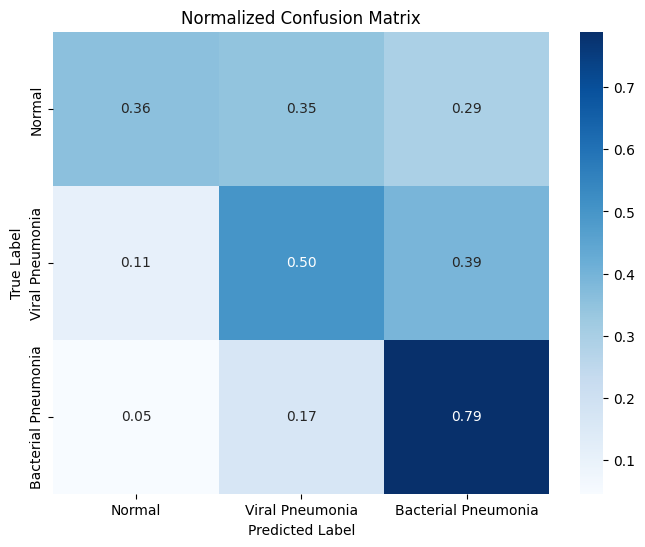

In [8]:
# Calculate metrics
def evaluate(y_pred):
    accuracy = accuracy_score(y_test, y_pred) # Accuracy
    conf_matrix = confusion_matrix(y_test, y_pred) # Confusion matrix
    class_report = classification_report(y_test, y_pred) # Classification report
    
    print(f"Accuracy: {accuracy:.4f}")
    
    print("Confusion Matrix:")
    print(np.array2string(conf_matrix))
    
    print("Classification Report:")
    print(class_report)

    plot_normalized_confusion_matrix(conf_matrix)

def plot_normalized_confusion_matrix(conf_matrix):
    # Normalize confusion matrix by row (true label count)
    conf_matrix_ratio = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_ratio, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Normal", "Viral Pneumonia", "Bacterial Pneumonia"], yticklabels=["Normal", "Viral Pneumonia", "Bacterial Pneumonia"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Normalized Confusion Matrix")

evaluate(basic_y_pred)

#### 3.3. Result analysis

The basic Decision Tree model achieved an accuracy of **55.93%**. While the model shows reasonable performance in identifying Bacterial Pneumonia (class 3) with a recall of 79% and a relatively high F1-score of 0.68, its ability to correctly classify Normal (class 1) and Viral Pneumonia (class 2) cases is noticeably weaker.

- Normal cases (class 1): 36% are correctly classified, but there is significant confusion with Viral Pneumonia (35%) and Bacterial Pneumonia (29%).
- Viral Pneumonia (class 2): Only 50% are correctly predicted, with 39% misclassified as Bacterial Pneumonia.
- Bacterial Pneumonia (class 3): 79% are correctly predicted, with fewer misclassifications compared to the other classes.

This imbalance, along with the tree's complexity, hints at overfitting to training data patterns without capturing broader trends.

### 4. Avoid Overfitting with Hyperparameter Tuning using Grid Search and K-Fold Cross-Validation

In this section, to avoid the ability of overfitting observed in the basic model, we apply **Grid Search** and **K-Fold Cross-Validation** for hyperparameter tuning. The goal is to identify the best combination of hyperparameters by splitting the training data into multiple folds, training on a subset, and validating on the rest. 

#### 4.1. Hyperparameter grid

We use the following hyperparameters for tuning:

- `max_depth`: Controls tree depth to balance under/overfitting.
- `min_samples_split`: Minimum samples required to split an internal node.
- `min_samples_leaf`: Minimum samples required to be a leaf node.

In [9]:
# Hyperparameter grid for tuning
param_grid = {
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 10, 50, 100],
    'min_samples_leaf': [1, 10, 50]
}

#### 4.2. Grid search with k-fold cross-validation and batch processing

Given the size of our training data (5284 samples, each with 16,384 features), direct grid search can cause memory issues. To address this, we use **batch processing** — a custom batch generator to load smaller subsets of data into memory during grid search. Batch processing can reduce memory load, ensuring that the hyperparameter tuning process can handle large datasets without exceeding system limits. 

The grid search iterates through all combinations of hyperparameters, applying K-Fold Cross-Validation to assess performance. The best parameters and corresponding accuracy are then determined after iterating through batches of training data.

In [10]:
# Define decision tree model to apply grid search
dt_model = DecisionTreeClassifier()

# Grid search definition with 5-fold cross-validation
# Best combination of parameters is determined based on the average accuracy on the validation set of the folds
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1
)

In [12]:
# Define batch generator
def batch_generator(X, y, batch_size=1000):
    n_samples = X.shape[0]
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        yield X[start:end], y[start:end]

# Fit in batches
for X_batch, y_batch in batch_generator(processed_X_train, y_train):
    grid_search.fit(X_batch, y_batch)

# Print the best parameters and score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/td07/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation accuracy: 0.70062656641604


In [14]:
# Retrain the final model on the entire training set
hyperparam_tuning_model = DecisionTreeClassifier(**grid_search.best_params_)
hyperparam_tuning_model.fit(processed_X_train, y_train)

# Print model summary
summarize_model(hyperparam_tuning_model)

Decision Tree Model Summary:
Number of features: 16384
Number of classes: 3
Tree depth: 10
Number of leaves: 208
Feature importances: [0. 0. 0. ... 0. 0. 0.]


#### 4.3. Prediction, evaluation and result analysis

In [15]:
# Make predictions on test data
hyperparam_y_pred = predict(hyperparam_tuning_model)
hyperparam_y_pred[:7]

array([2, 2, 2, 2, 2, 2, 3])

Accuracy: 0.6042
Confusion Matrix:
[[ 84  90  60]
 [ 14  82  52]
 [  9  22 211]]
Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.36      0.49       234
           2       0.42      0.55      0.48       148
           3       0.65      0.87      0.75       242

    accuracy                           0.60       624
   macro avg       0.62      0.59      0.57       624
weighted avg       0.65      0.60      0.59       624



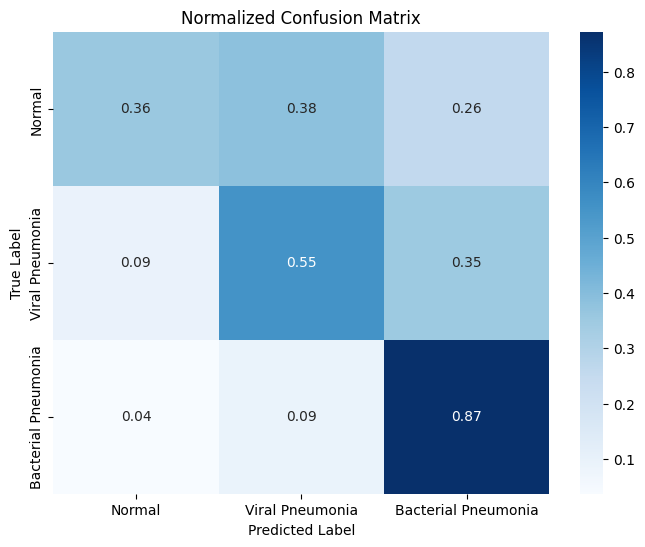

In [16]:
# Evaluate prediction results
evaluate(hyperparam_y_pred)

We can see that the tuned tree, limited to a depth of 10, shows a better balance between bias and variance by preventing overfitting. It achieved an accuracy of **60.42%** (greater than 55.93% of the basic tree). Looking into each class, we observe:

- Class 1 (Normal): Precision improved slightly (from 0.76 to 0.79), but recall remained the same.
- Class 2 (Viral Pneumonia): Recall increased to 0.55 compared to the basic tree, indicating the model is now slightly better at identifying this class.
- Class 3 (Bacterial Pneumonia): Recall remains strong at 0.87, suggesting the tuned tree retains high sensitivity for this class.

The normalized confusion matrix also shows that misclassification between Normal and Viral Pneumonia remains a challenge. 

Overall, the grid search approach successfully reduced model complexity and boosted generalization, though additional improvements may still be needed.

### 5. Improve the Basic Model by Post-pruning

Now we further refine the basic model through post-pruning by tuning the ccp_alpha parameter. 

Cost Complexity Pruning (CCP) is a technique to simplify the Decision Tree by removing branches that provide little improvement in model performance. This helps to reduce overfitting and improve generalization. 

The pruning process works by introducing a complexity parameter $\alpha$, known as ccp_alpha. Increasing $\alpha$ penalizes more complex trees, encouraging simpler models. The goal is to find an optimal $\alpha$ that balances model accuracy and complexity.

#### 5.1. Retrieve effective values of $\alpha$

Now we use function `cost_complexity_pruning_path` on the basic decision tree model trained in section 3 to get the sequence of effective $\alpha$ values, where pruning actually changes the structure of the tree and the tree gets simpler.

In [18]:
ccp_alphas = np.unique(basic_model.cost_complexity_pruning_path(processed_X_train, y_train)["ccp_alphas"])
print("Number of ccp_alphas: ", len(ccp_alphas))
print(np.array2string(ccp_alphas[:7]))

Number of ccp_alphas:  279
[0.         0.0001857  0.00018638 0.00018688 0.00018749 0.00018895
 0.00018925]


#### 5.2. Perform post-pruning and obtain the best $\alpha$

For each $\alpha$ in `ccp_alphas` array, we will train the corresponding (pruned) decision tree and get the prediction on the test data to see its impact. Then the best $\alpha$ will be the one with the highest accuracy.

In [20]:
# Track best parameters
best_alpha = None
best_score = 0
best_pruning_model = None
results = []

# Post-pruning 
for ccp_alpha in ccp_alphas:
    pruned_tree = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    pruned_tree.fit(processed_X_train, y_train)
    y_test_pred = predict(pruned_tree)
    val_accuracy = accuracy_score(y_test, y_test_pred)

    y_train_pred = pruned_tree.predict(processed_X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    results.append((ccp_alpha, train_accuracy, val_accuracy))
    
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_alpha = ccp_alpha
        best_pruning_model = pruned_tree
    elif val_accuracy == best_score:
        best_alpha = ccp_alpha
        best_pruning_model = pruned_tree

print(f"Best pruning parameter (ccp_alpha): {best_alpha:.8f} with accuracy {best_score:.4f}")
summarize_model(best_pruning_model)

Best pruning parameter (ccp_alpha): 0.00373069 with accuracy 0.6410
Decision Tree Model Summary:
Number of features: 16384
Number of classes: 3
Tree depth: 6
Number of leaves: 17
Feature importances: [0. 0. 0. ... 0. 0. 0.]


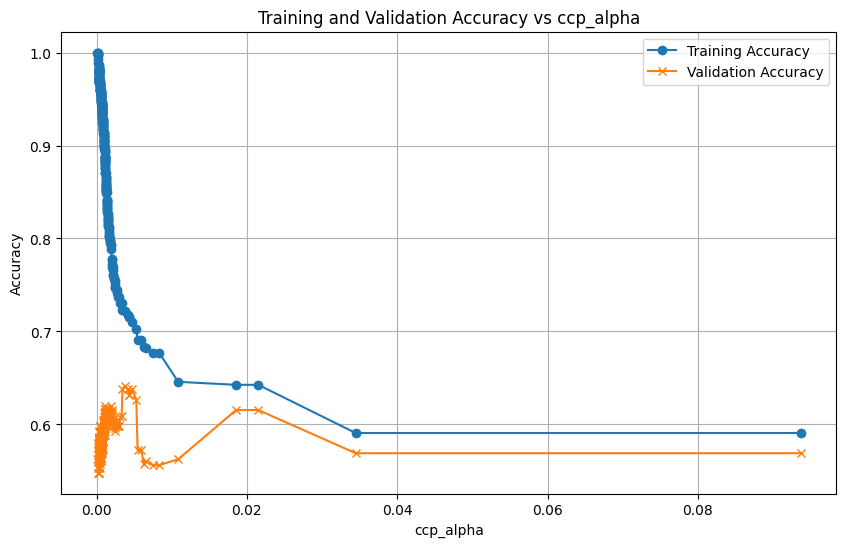

In [21]:
# Convert results array to separate arrays for plotting
ccp_alpha_values, train_accuracies, val_accuracies = zip(*results)

# Plot accuracy vs ccp_alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alpha_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(ccp_alpha_values, val_accuracies, marker='x', label='Validation Accuracy')
plt.xlabel('ccp_alpha')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs ccp_alpha')
plt.legend()
plt.grid(True)
plt.show()

#### 5.3. Re-evaluate pruned decision tree and analyze result

Accuracy: 0.6410
Confusion Matrix:
[[100  66  68]
 [ 16  72  60]
 [  9   5 228]]
Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.43      0.56       234
           2       0.50      0.49      0.49       148
           3       0.64      0.94      0.76       242

    accuracy                           0.64       624
   macro avg       0.65      0.62      0.60       624
weighted avg       0.67      0.64      0.62       624



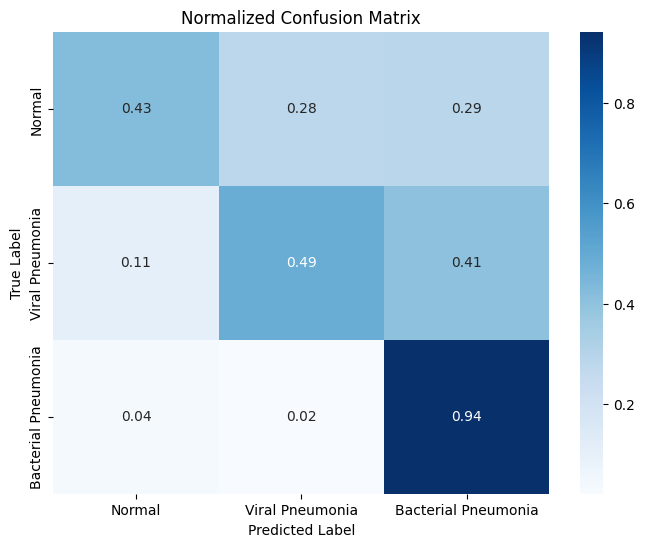

In [24]:
# Predictions on test data
pruning_y_pred = predict(best_pruning_model)
# Evaluate prediction results
evaluate(pruning_y_pred)

The final pruned tree achieves an accuracy of **64.10%**, showing a slight improvement over the unpruned tree's 55.93%. Let’s break it down:

- Class 1 (Normal): precision increased from 0.76 to 0.80, recall improved from 0.36 to 0.43.
- Class 2 (Viral Pneumonia): precision rose from 0.38 to 0.50, recall dropped slightly from 0.50 to 0.49.
- Class 3 (Bacterial Pneumonia): precision increased from 0.60 to 0.64, recall improved from 0.79 to 0.94.

It can be seen that the pruned tree does a better job distinguishing Bacterial Pneumonia. The misclassification rate between Normal and Viral Pneumonia still remains high, though there’s a small shift in predicting Viral Pneumonia and identifying Normal more accurately. This suggests the features may not be fully separable for those classes — possibly pointing to the need for further feature engineering or a more complex model.

### 6. Conclusion

Until now, we have applied Decision Trees to classify images from the CoronaHack Chest X-Ray dataset with the process involving:

- Basic Decision Tree: Building a fully grown tree with 55.93% accuracy, showing overfitting with 37 levels and 505 leaves.
- K-Fold Cross-Validation with Grid Search: Tuning `max_depth`, `min_samples_split`, and `min_samples_leaf` using 5-fold cross-validation, finding the best combination and obtaining the model with accuracy 60.42%.
- Post-pruning (Cost Complexity Pruning): Using cost complexity pruning (`ccp_alpha`) to simplify the tree, choosing an optimal $\alpha$ to reduce complexity. The final pruned tree reached 64.10% accuracy — a balance between complexity and performance.

Using the decision tree can have several advantages:

- Intuitive and easy to visualize, aiding interpretability.
- Handles both numerical and categorical data.
- Minimal preprocessing required, making implementation simple.
- Able to capture non-linear relationships between features and targets.
- Allows for feature importance ranking, highlighting which attributes impact predictions most.

Besides, there are also drawbacks in using this kind of model:

- Prone to overfitting without pruning or hyperparameter tuning.
- Sensitive to data variations, resulting in instability.
- Biased towards features with more levels, impacting splits.
- Limited extrapolation ability, as splits are axis-parallel and may struggle with complex patterns.
- Less effective for small datasets with noisy features.

In summary, Decision Trees provided a solid baseline for classifying chest X-ray images, revealing both their strengths in interpretability and their limitations in handling overfitting. Further improvements could be achieved by leveraging ensemble methods